In [ ]:
# External libs
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import importlib

# My modules (must be in the same folder of main.ipynb)
import functions.autoregressive as ar
import functions.statFunctions as stat

In [3]:
importlib.reload(ar) # if autoregressiveFunctions.py is modified 
importlib.reload(stat) # if statFunctions.py is modified 

<module 'functions.statFunctions' from 'c:\\Users\\alber\\python_projects\\fundamentals_of_interest_rates\\functions\\statFunctions.py'>

# Autoregressive (AR) Processes

An autoregressive (AR) process is a type of time series model where the current value of the series depends linearly on its past values and a random shock (innovation). 

#### General AR(p)
A general AR(p) process depends on the last \(p\) lags:

$$
y_t = a_0 + a_1 y_{t-1} + a_2 y_{t-2} + \dots + a_p y_{t-p} + \varepsilon_t
$$

- The order \(p\) indicates how many past values influence the current value. 

- $a_0$ is a constant term  
- $a_1$ is an autoregressive coefficient  
- $\varepsilon_t$ is a white noise error term





100%|██████████| 996/996 [00:00<00:00, 89353.13it/s]


4 different AR(4) processes of 998 steps have been generated with increments following t distribution


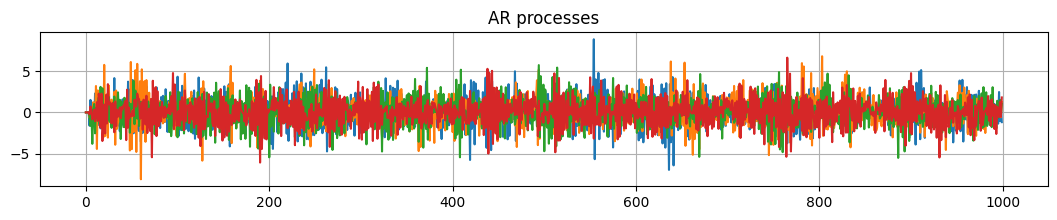

In [4]:
a = np.array([0.1, -0.5, 0.3, 0.4, -0.2])

data = ar.generate_ar(steps=1000, paths=4, a=a, start=0, dist='t', error_var=1, degree_f=6)
ar.plot_paths(data, size=(13,2))

### Stationarity

In general, an AR(p) is stationary if the roots of the characteristic polynomial lie outside the unit circle.

For an autoregressive process AR(p), the characteristic polynomial is defined as:

$$
\phi(z) = 1 - a_1 z - a_2 z^2 - \dots - a_p z^p
$$

So, it is stationary if:

$$
|z_i| > 1 \quad \forall i
$$

This condition ensures that the effect of past shocks decays over time and the process does not diverge.

Let's check this facts empirically

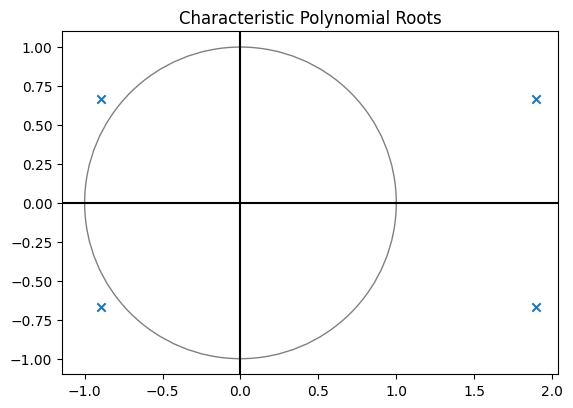

The process is stationary!


In [5]:
roots = ar.characteristic_poly_roots(a, show_plot=True)

if np.all((np.absolute(roots)) > 1):
    print('The process is stationary!')
else:
    print('The process is not stationary')

We can see this fact visually:

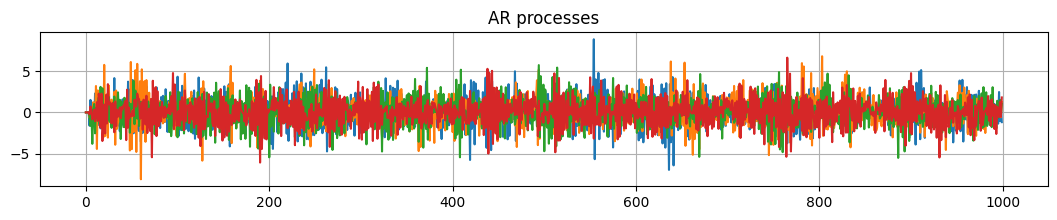

In [6]:
ar.plot_paths(data, size=(13,2))

Let's try an other example:

In [7]:
a = np.array([0.3, 1, -0.3, 0.3])

data = ar.generate_ar(steps=1000, paths=30, a=a, start=0, dist='normal', error_var=1.5)

100%|██████████| 997/997 [00:00<00:00, 100189.78it/s]

30 different AR(3) processes of 999 steps have been generated with increments following normal distribution


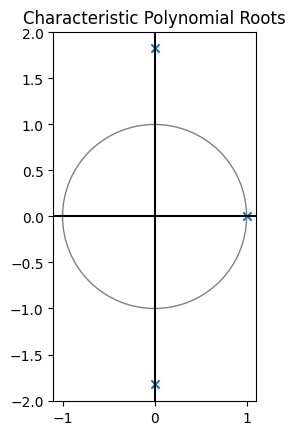

The process is not stationary


In [8]:
roots = ar.characteristic_poly_roots(a, show_plot=True)

if np.all((np.absolute(roots)) > 1):
    print('The process is stationary!')
else:
    print('The process is not stationary')

In fact:

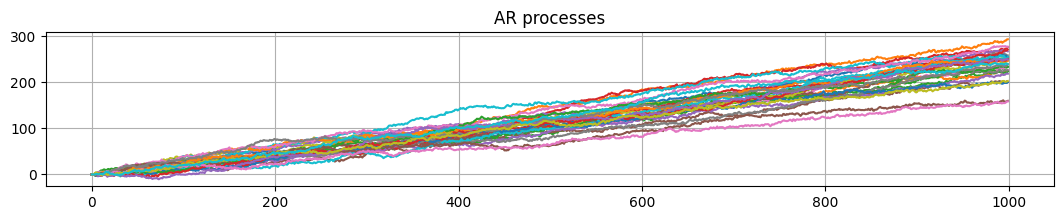

In [9]:
ar.plot_paths(data, size=(13,2))

As a consequence of stationarity, we have that:

1. The **mean** is constant:

$$
\mathbb{E}[y_t] = \frac{a_0}{1 - a_1 - \dots - a_p}
$$

2. The **variance** is finite and constant (this formula is for AR(1) only, for p>1 we need to solve Yule-Walker system):

$$
\mathrm{Var}(y_t) = \frac{\sigma^2}{1 - a_1^2}
$$

3. The **autocovariance** depends only on the lag \(k\):

$$
\gamma_k = \mathrm{Cov}(y_t, y_{t-k})
$$

Now let's check if increasing the # of steps we see a convergence of the sample mean toward the theoretical mean

In [10]:
a = np.array([0.1, -0.5, 0.3, 0.4, -0.2])
steps_list = [100, 1_000, 10_000, 100_000, 1_000_000]

simulations = ar.iterate_simulations(steps_list, paths=1, a=a, error_var=1)

In [11]:
theoretic_mean = (a[0]/(1 - np.sum(a[1:])))
sample_means = [np.mean(sim, axis=0).mean() for sim in simulations.values()]

result = df({'steps': steps_list,'sample_mean': sample_means})
result['sample_mean'] = result['sample_mean'].round(6)

result = pd.concat([result, df({'steps': ['theoretical'], 'sample_mean': [round(theoretic_mean, 6)]})], ignore_index=True)
display(result)


,steps,sample_mean
0,100,0.028918
1,1000,0.069320
2,10000,0.089499
3,100000,0.095749
4,1000000,0.100096
5,theoretical,0.100000


Okay we actually see a convergence. Let's see what happens for the variance. For this we have to simulate an AR(1):

In [12]:
sigma_2 = 1
simulations_ar1 = ar.iterate_simulations(steps_list, paths=1, a=np.array([0.3, 0.6]), error_var=sigma_2)

In [13]:
theoretic_variance = (sigma_2 / (1 - np.sum(a[1]**2)))  
sample_vars = [np.var(sim, ddof=1, axis=0).mean() for sim in simulations_ar1.values()]

result = df({'steps': steps_list,'sample_var': sample_vars})
result['sample_var'] = result['sample_var'].round(6)

result = pd.concat([result, df({'steps': ['theoretical'], 'sample_var': [round(theoretic_variance, 6)]})], ignore_index=True)
display(result)


,steps,sample_var
0,100,1.010379
1,1000,1.643115
2,10000,1.591492
3,100000,1.573553
4,1000000,1.561692
5,theoretical,1.333333


Let's check if the autocovariance depends on lag k only

lunj box, brash pagan
aggiungi formula bartlett (per autocorr)
(sopra aggiungi adf)

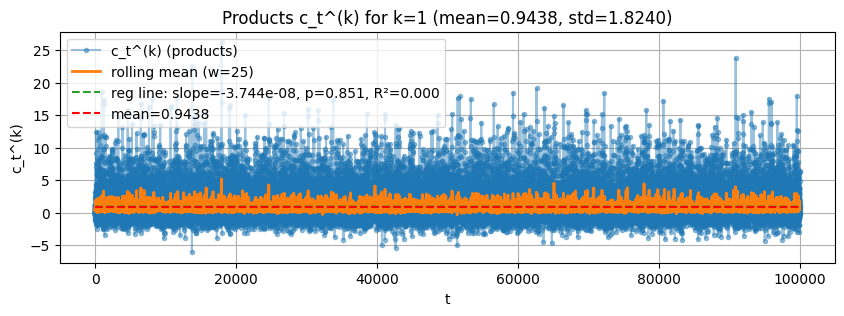

In [14]:
stat.check_autocovariance_stationarity(simulations_ar1[100000].flatten(),max_lag=1, plot=True,  window=25, min_points_for_regression=10)

As expected, the rolling mean remains stable over time and the regression shows no significant relationship between the covariance products and time. This provides empirical evidence that the autocovariance depends only on the lag k, supporting the assumption of covariance-stationarity.

### Fitting an AR(p) Model using OLS

We assume a time series that follows an AR(p) process:

$$
y_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p} + \varepsilon_t
$$

---

#### Matrix Representation

Let:

- \(Y\) = vector of observed values starting from lag \(p\):

$$
Y =
\begin{bmatrix}
y_p \\
y_{p+1} \\
\vdots \\
y_T
\end{bmatrix}
$$

- \(X\) = design matrix of lagged values:

$$
X =
\begin{bmatrix}
1 & y_{p-1} & y_{p-2} & \dots & y_{0} \\
1 & y_{p} & y_{p-1} & \dots & y_{1} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & y_{T-1} & y_{T-2} & \dots & y_{T-p}
\end{bmatrix}
$$

Then the AR(p) model is:

$$
Y = Xa + \varepsilon
$$

where:

$$
a =
\begin{bmatrix}
a_0 \\
a_1 \\
\vdots \\
a_p
\end{bmatrix}
$$

---

#### OLS Estimator

The OLS solution (least squares estimator) is:

$$
\hat{a} = (X^\top X)^{-1} X^\top Y
$$


In [16]:
a = np.array([0.1, -0.5, 0.3, 0.4, -0.2])
p = a.size -1

y_t = ar.generate_ar(steps=10_000, paths=10, a=a, start=0, dist='normal', error_var=1)

coefficients = ar.fit_ar_ols(y_t, p=p)
df(np.vstack([np.mean(coefficients, axis=1),a]).T).rename(columns={0: 'avg fitted coefficient', 1:'real coefficient'})

100%|██████████| 9996/9996 [00:00<00:00, 184290.45it/s]

10 different AR(4) processes of 9998 steps have been generated with increments following normal distribution


,avg fitted coefficient,real coefficient
0,0.096171,0.1
1,-0.506988,-0.5
2,0.294568,0.3
3,0.401815,0.4
4,-0.194288,-0.2


### Consistency of the OLS Estimator

Under standard assumptions — independent errors with finite variance and no perfect multicollinearity —  
the OLS estimator for an AR(p) model is **consistent**.

This means that as the number of observations \(T\) increases:

$$
\hat{a} \xrightarrow[T \to \infty]{} a
$$

In other words, the estimated parameters converge to the true data-generating values.

Let's check this empirically:


In [17]:
steps_list = [100, 1_000, 10_000, 100_000]
simulations_normal = ar.iterate_simulations(steps_list, paths=5, a=a, dist='normal', error_var=1)

coef = ar.iterate_fit_ar_ols(simulations, p=p, return_df=True)
coef['Real coefficient'] = a

display(coef)

,100,1000,10000,100000,1000000,Real coefficient
0,0.038919,0.069312,0.090904,0.095925,0.100551,0.1
1,-0.376548,-0.417850,-0.492387,-0.499174,-0.499728,-0.5
2,0.406954,0.330001,0.307169,0.299811,0.299632,0.3
3,0.353552,0.357124,0.389766,0.396546,0.397527,0.4
4,-0.337755,-0.260254,-0.218575,-0.198937,-0.201973,-0.2


Now let's try an other technique of estimation:

### Maximum Likelihood Estimation

The Maximum Likelihood Estimator (MLE) finds the parameter values that maximize the probability of observing the given data.  
Formally, for parameters $\theta$:

$$
\hat{\theta} = \arg\max_\theta \mathcal{L}(\theta \mid \text{data})
$$

or equivalently using the log-likelihood:

$$
\hat{\theta} = \arg\max_\theta \ell(\theta \mid \text{data})
$$

---

### AR(p) with Gaussian Innovations

For an AR(p) process with $\varepsilon_t \sim t_{\nu}(0, \sigma^2)$:

$$
y_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p} + \varepsilon_t, 
\quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

The log-likelihood becomes:

$$
\ell(a_0, \dots, a_p, \sigma^2) 
= -\frac{T-p}{2} \log(2 \pi) - \frac{T-p}{2} \log(\sigma^2) 
- \frac{1}{2\sigma^2} \sum_{t=p}^T (y_t - \mu_t)^2
$$

where

$$
\mu_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p}
$$

---

### AR(p) with Student-t Innovations

$$
y_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p} + \varepsilon_t, 
\quad \varepsilon_t \sim t_\nu(0, \sigma^2)
$$

where $t_\nu$ is a Student-t distribution with $\nu$ degrees of freedom, zero mean, and scale $\sigma^2$.


$$
\ell(a_0, \dots, a_p, \sigma^2, \nu) 
= \sum_{t=p}^T \log \left[ 
\frac{\Gamma\Big(\frac{\nu+1}{2}\Big)}{\Gamma\Big(\frac{\nu}{2}\Big) \sqrt{\pi \nu \sigma^2}} 
\left( 1 + \frac{(y_t - \mu_t)^2}{\nu \sigma^2} \right)^{-\frac{\nu+1}{2}} 
\right]
$$

---

The MLEs are obtained by maximizing the log-likelihood

- This requires numerical optimization, e.g., using `scipy.optimize.minimize`.
- As $T \to \infty$, the MLEs converge to the true parameters under regularity conditions.
- Using Student-t innovations allows the model to handle **heavy-tailed shocks**, unlike the Gaussian case.


Let's try gaussian case:

In [18]:
a = np.array([0.2, 0.4, -0.2])
sigma_2 = 1
nu = 8

p = a.size -1
steps_list = [100, 1000, 10_000, 100_000]

In [19]:
simulations_normal = ar.iterate_simulations(steps_list, paths=5, a=a, dist='normal', error_var=sigma_2, degree_f=None)
coef = ar.iterate_fit_ar_ML(simulations_normal, p=p, dist='normal', return_df=True)
real_coef = np.hstack([a,[sigma_2]])
coef['Real coef'] = real_coef
coef = coef.rename(index={p+1: 'sigma^2'})
display(coef)

a_hat_norm = coef[100000][:-1] # Best estimate of AR(p) coefficients in order to study residuals

,100,1000,10000,100000,Real coef
0,0.188407,0.163091,0.202332,0.200819,0.2
1,0.375612,0.397585,0.383371,0.399404,0.4
2,-0.188862,-0.207195,-0.189392,-0.200663,-0.2
sigma^2,0.929352,0.944639,1.007454,1.002119,1.0


Now with student t innovations

In [20]:
simulations_t = ar.iterate_simulations(steps_list, paths=5, a=a, dist='t', error_var=sigma_2, degree_f=nu)
coef = ar.iterate_fit_ar_ML(simulations_t, p=p, dist='t', return_df=True)
real_coef = np.hstack([a,[sigma_2, nu]])
coef['Real coef'] = real_coef
coef = coef.rename(index={p+1: 'sigma^2', p+2: 'nu'})
display(coef)

a_hat_t = coef[100000][:-2] # Best estimate of AR(p) coefficients necessary for studying residuals

,100,1000,10000,100000,Real coef
0,0.108625,0.157981,0.197252,0.199120,0.2
1,0.392449,0.420551,0.399096,0.401173,0.4
2,-0.110752,-0.251497,-0.216169,-0.204512,-0.2
sigma^2,0.857566,0.997237,0.999013,1.004102,1.0
nu,7.755837,9.777398,8.645719,8.137878,8.0


Suppose we have a time series generated from an AR(p) process with **normal innovations**:

$$
y_t = a_0 + a_1 y_{t-1} + \dots + a_p y_{t-p} + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

We can fit two AR(p) models:

1. **Gaussian likelihood**  
2. **Student-t likelihood** (adds an extra parameter $\nu$)

AIC and BIC are defined as:

$$
\text{AIC} = 2k - 2\ell(\hat{\theta}), \quad
\text{BIC} = k \ln(T) - 2\ell(\hat{\theta})
$$

where $k$ is the number of estimated parameters, $T$ is the number of observations, and $\ell(\hat{\theta})$ is the log-likelihood.

**Expectation:**  

- Gaussian model is the true model → log-likelihood is higher (negloglik lower).  
- Student-t model has extra parameter → AIC/BIC penalize complexity.  
- Since the data are normal, Student-t does **not improve fit significantly**, so we expect:

$$
\text{AIC}_{\text{Gaussian}} < \text{AIC}_{\text{Student-t}}, \quad
\text{BIC}_{\text{Gaussian}} < \text{BIC}_{\text{Student-t}}
$$


Let's generate an AR with normal innovations and then compute AIC and BIC using ML estimation both with normal and student t.

In [43]:
T = 10_000
a = np.array([0.2, 0.5, -0.2])

data = ar.generate_ar(steps=T, paths=3, a=a, dist='normal', error_var=1)

res_n = ar.fit_ar_ML(data, p=p, dist='normal', return_res=True)
res_t = ar.fit_ar_ML(data, p=p, dist='t', return_res=True)

100%|██████████| 9998/9998 [00:00<00:00, 227381.75it/s]


3 different AR(2) processes of 10000 steps have been generated with increments following normal distribution


In [54]:
#print(res_n)
#print(res_t)

In [53]:
aic_n = ar.aic(res_n.fun, res_n.x.size)
bic_n = ar.bic(res_n.fun, res_n.x.size, T)

aic_t = ar.aic(res_t.fun, res_t.x.size)
bic_t = ar.bic(res_t.fun, res_t.x.size, T)

df_ic = df({
    "Model": [f"Gaussian AR({a.size-1})", f"Student-t AR({a.size-1})"],
    "AIC": [aic_n, aic_t],
    "BIC": [bic_n, bic_t]
})

display(df_ic)

,Model,AIC,BIC
0,Gaussian AR(2),28452.001640,28480.843001
1,Student-t AR(2),28457.988023,28494.039725


Let's try the opposite situation

In [56]:
data = ar.generate_ar(steps=T, paths=3, a=a, dist='t', error_var=1, degree_f=4)

res_n = ar.fit_ar_ML(data, p=p, dist='normal', return_res=True)
res_t = ar.fit_ar_ML(data, p=p, dist='t', return_res=True)

aic_n = ar.aic(res_n.fun, res_n.x.size)
bic_n = ar.bic(res_n.fun, res_n.x.size, T)

aic_t = ar.aic(res_t.fun, res_t.x.size)
bic_t = ar.bic(res_t.fun, res_t.x.size, T)

df_ic = df({
    "Model": [f"Gaussian AR({a.size-1})", f"Student-t AR({a.size-1})"],
    "AIC": [aic_n, aic_t],
    "BIC": [bic_n, bic_t]
})

display(df_ic)

100%|██████████| 9998/9998 [00:00<00:00, 239021.51it/s]


3 different AR(2) processes of 10000 steps have been generated with increments following t distribution


,Model,AIC,BIC
0,Gaussian AR(2),35472.434110,35501.275471
1,Student-t AR(2),33482.482526,33518.534228


As we expected AIC and BIC are now higher for gaussian 

---

---

---

## Studying residuals

Now let's do some test on residuals

First of all let's get standard residuals wrt the best estimators of the of the coefficients of AR(p) that we have (the ones on 100'000 steps)

In [21]:
std_residuals_norm = ar.get_residuals(data = simulations_normal[100000], coefficients = np.array(a_hat_norm), p=p, std_residuals = True)
std_residuals_t = ar.get_residuals(data = simulations_t[100000], coefficients = np.array(a_hat_t), p=p, std_residuals = True)

100%|██████████| 99998/99998 [00:01<00:00, 74741.99it/s] 


Now we can check moments 

In [22]:
display(stat.compute_moments(std_residuals_norm).mean(axis=1))
display(stat.compute_moments(std_residuals_t).mean(axis=1))

mean       -0.001159
variance    1.000000
skewness    0.006258
kurtosis    3.009311
dtype: float64

mean        0.001841
variance    1.000000
skewness   -0.005968
kurtosis    4.082322
dtype: float64

We see that the mean and the skewness in both cases is close to zero, the variance close to one (since are standardized) and the kurtosis, in the gaussian case, is 3 and in the student t is 4. This is coherent with the assumptions and the setting. We can also perform a Jarque-Bera test to check for normality.

In [23]:
display(stat.jb_test(std_residuals_norm).mean(axis=1))
display(stat.jb_test(std_residuals_t).mean(axis=1))

jb stat    3.940941
p value    0.347511
dtype: float64

jb stat    4891.75924
p value       0.00000
dtype: float64

As we expected we cannot reject H0 of normality in the first case and we have to reject it in the second.

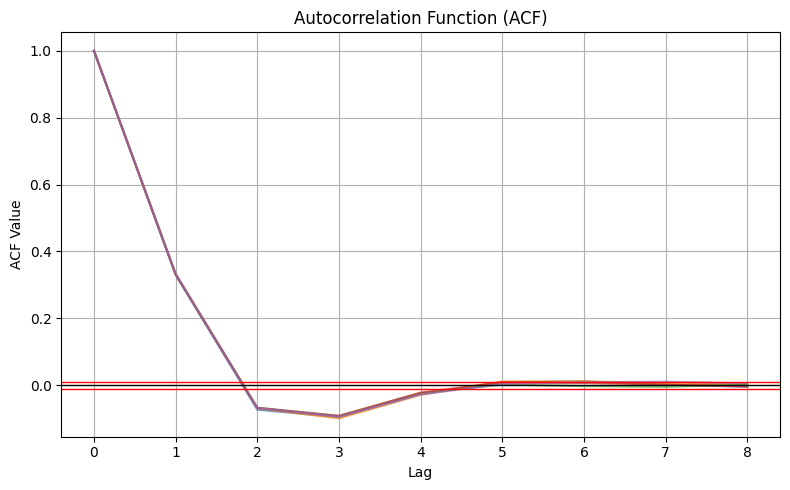

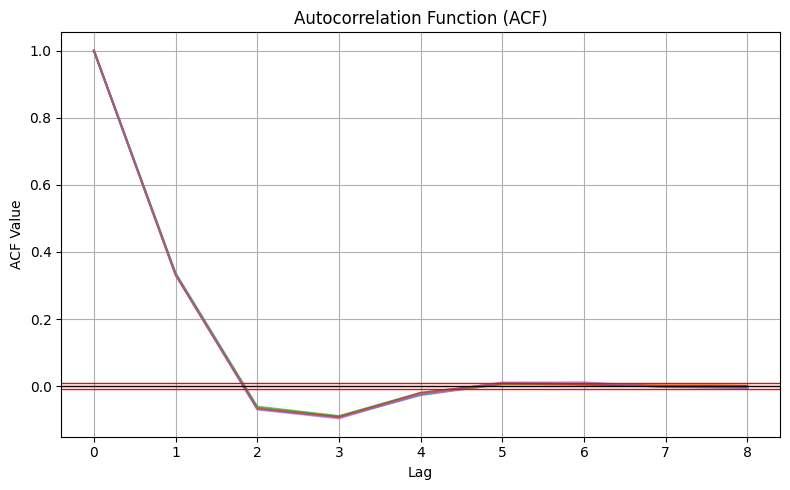

In [58]:
acf_summary_norm = stat.auto_correlation_function(std_residuals_norm, p=8)
stat.plot_acf(acf_summary_norm, steps=10000)

acf_summary_t = stat.auto_correlation_function(std_residuals_t, p=8)
stat.plot_acf(acf_summary_t, steps=10000)

We expect very low acf indicating that the model captures most of autocorrelation effect

We can see autocorrelation at lags 1  2 and 3 but after the AR effect decays

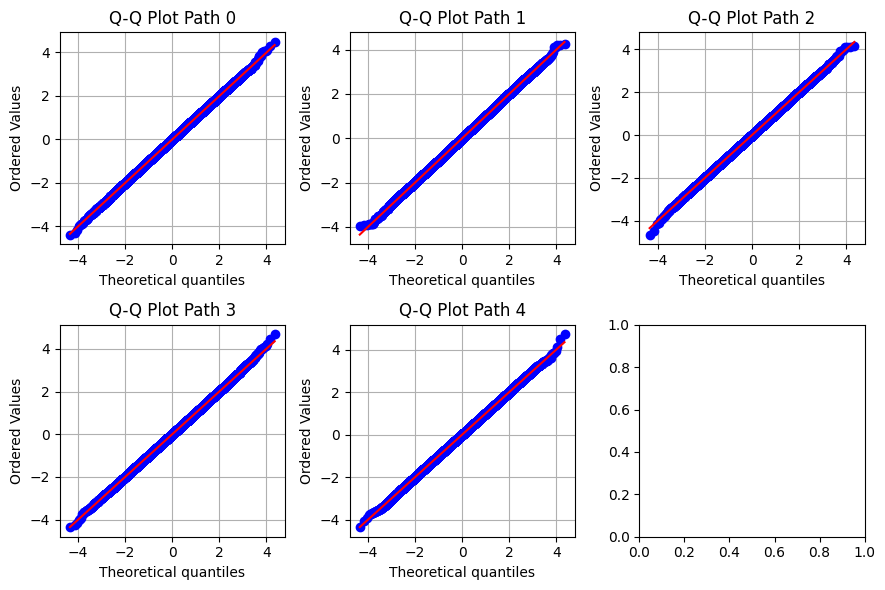

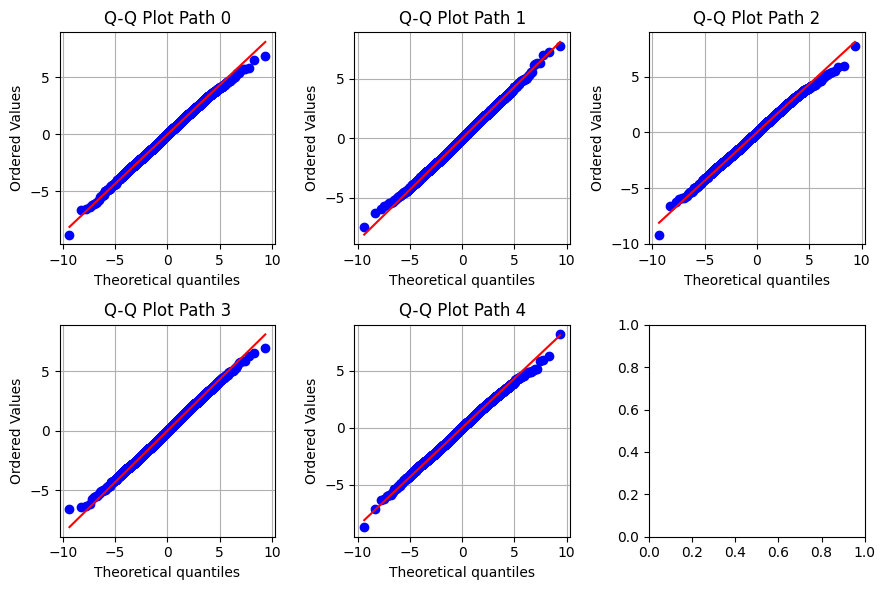

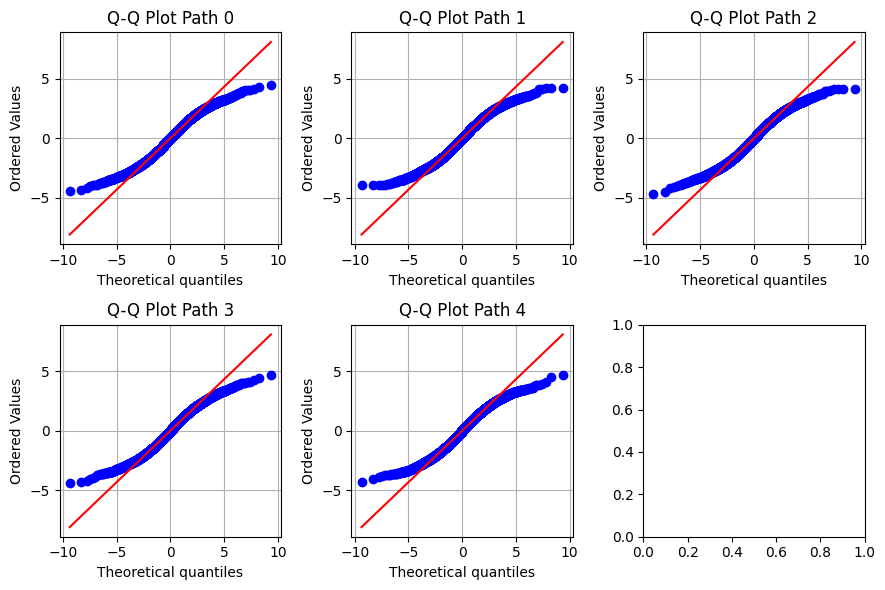

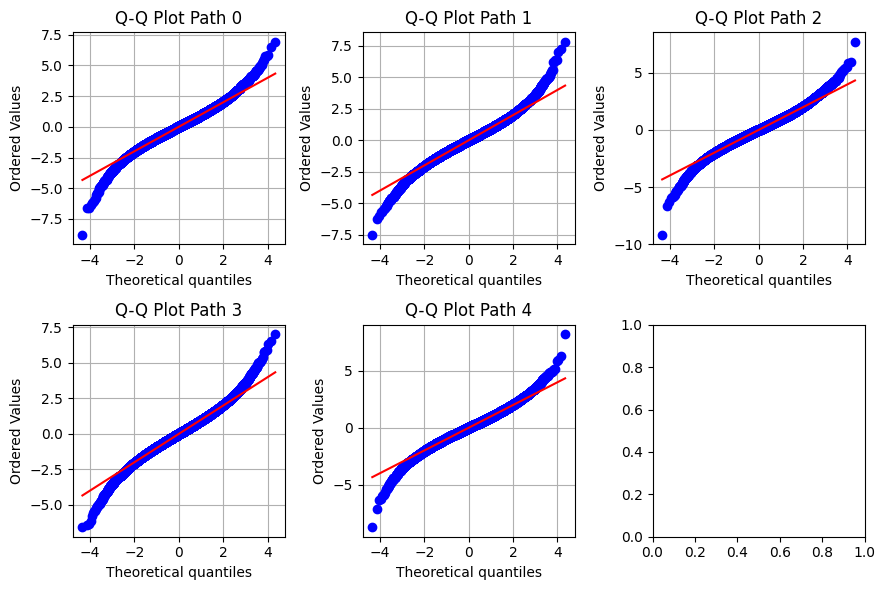

In [25]:
stat.qq_plot(std_residuals_norm, dist='normal', ncols=3) 
stat.qq_plot(std_residuals_t, dist='t', ncols=3, df=8) 

stat.qq_plot(std_residuals_norm, dist='t', ncols=3) # normal vs t
stat.qq_plot(std_residuals_t, dist='normal', ncols=3, df=8) # t vs normal 

In the first two plots we see gaussian and student t errors against the respective theoretical distribution. In the second two we inverted the distribution and we see that normal againt student t has less heavier tails and that t versus nomrmal has heavier tails.